In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/isles-2022-brain-stoke-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/isles-2022-brain-stoke-dataset


Found 250 cases. Initializing generator...
Fetching and visualizing the first randomized batch...


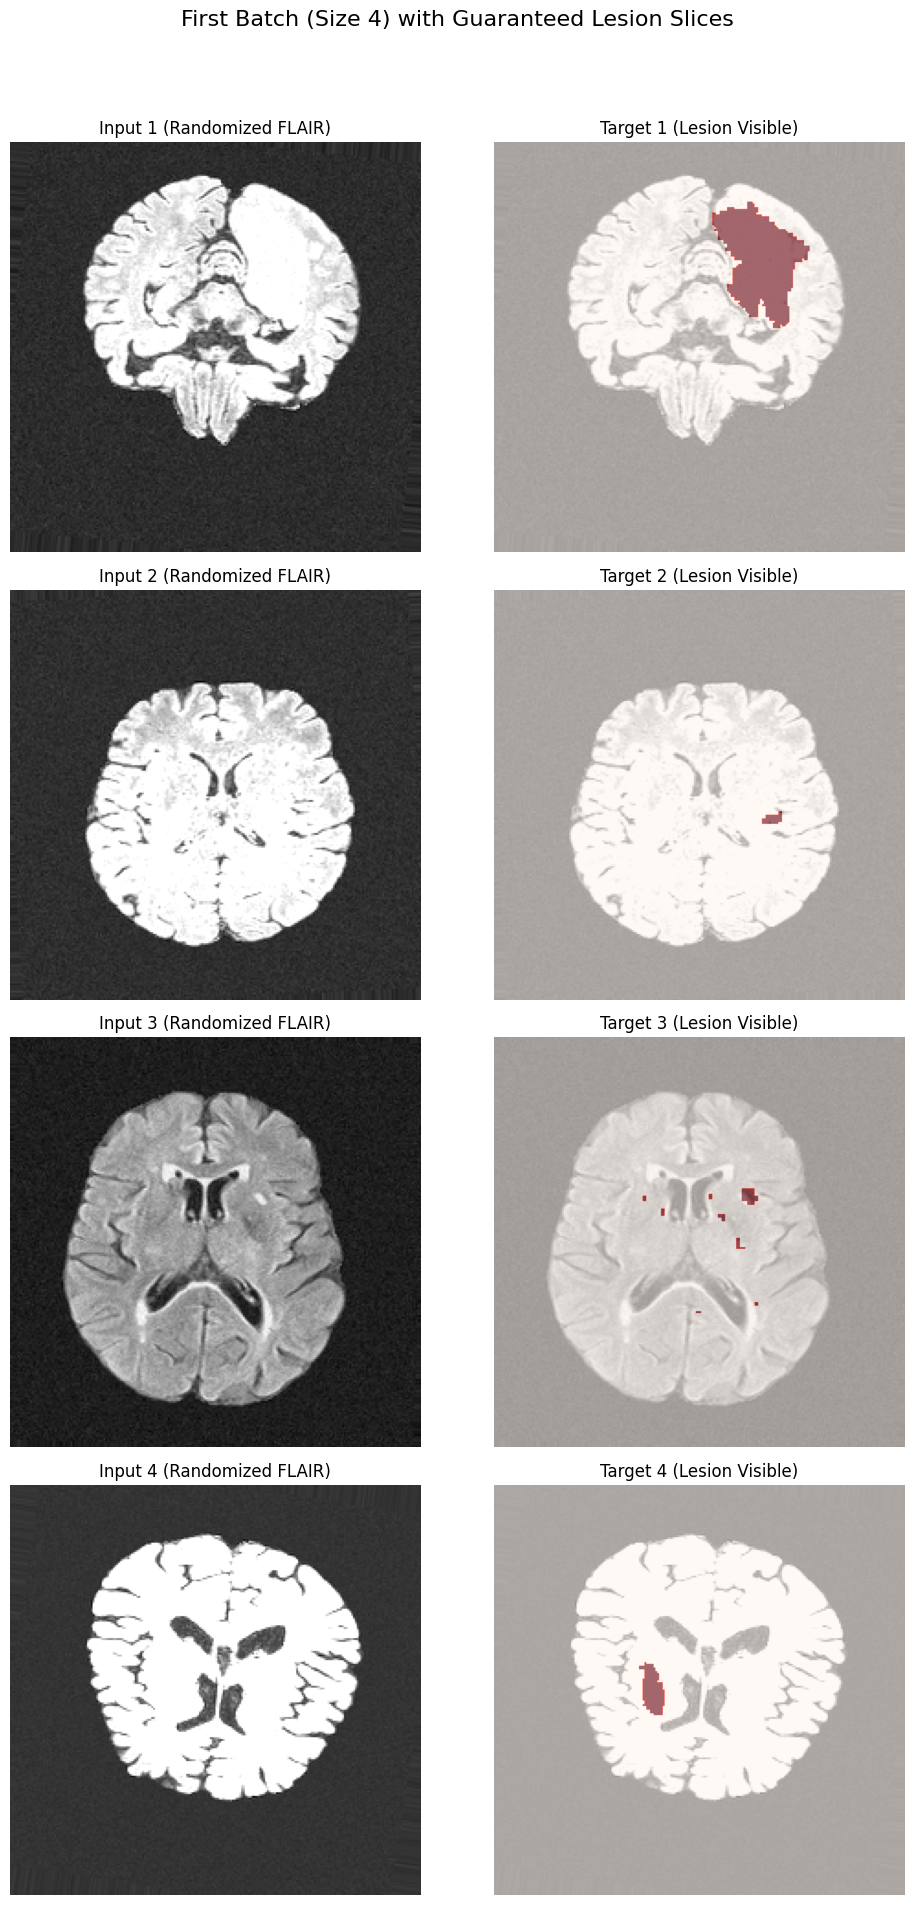

Batch shapes: Input (X): (4, 224, 224, 1), Target (Y): (4, 224, 224, 1)


In [20]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from nibabel.processing import resample_from_to
from tensorflow.keras.utils import Sequence
# ADDED: Import for efficient N-D array resizing
from scipy.ndimage import zoom, rotate
# --- Configuration Constants ---
BASE_DIR = "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022"
DERIVATIVES_DIR = os.path.join(BASE_DIR, "derivatives")
SESSION_ID = "ses-0001"
IMG_SIZE = (224, 224) # Target size for a common model input
BATCH_SIZE = 4       # Small batch size for visualization

# --- Helper Function for Resizing (Fix for plt.resize error) ---

def resize_slice(data, new_size, is_mask=False):
    """
    Resizes a 2D numpy array using scipy.ndimage.zoom.
    """
    current_h, current_w = data.shape
    target_h, target_w = new_size
    
    # Calculate zoom factors
    zoom_factors = (target_h / current_h, target_w / current_w)
    
    # Order=3 (cubic) for image; Order=0 (nearest neighbor) for labels
    interpolation_order = 0 if is_mask else 3
    
    # The actual resizing function
    resized_data = zoom(data, zoom_factors, order=interpolation_order)
    
    return resized_data


# --- 1. Generator Class for NIfTI Domain Randomization ---

class KaggleNiftiGenerator(Sequence):
    """
    Keras Sequence for CPU-friendly 3D NIfTI data loading, resampling, and Domain Randomization (DR).
    """
    def __init__(self, case_ids, base_dir, derivatives_dir, session_id, img_size, batch_size):
        self.case_ids = case_ids
        self.base_dir = base_dir
        self.derivatives_dir = derivatives_dir
        self.session_id = session_id
        self.img_size = img_size
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.floor(len(self.case_ids) / self.batch_size))

    def on_epoch_end(self):
        """Updates case_ids after each epoch (shuffling for next epoch)."""
        random.shuffle(self.case_ids)

    def _load_and_process_volume(self, case_id):
        """Loads, resamples, and extracts a 2D slice from one NIfTI pair."""
        
        # Construct paths
        flair_path = os.path.join(self.base_dir, case_id, self.session_id, "anat", f"{case_id}_{self.session_id}_FLAIR.nii")
        mask_path = os.path.join(self.derivatives_dir, case_id, self.session_id, f"{case_id}_{self.session_id}_msk.nii")

        # Load images
        flair_img = nib.load(flair_path)
        mask_img = nib.load(mask_path)
        
        # Resample mask to FLAIR space
        resampled_mask = resample_from_to(mask_img, flair_img, order=0) # order=0 is nearest neighbor

        # Get data and normalize FLAIR
        flair_data = flair_img.get_fdata().astype(np.float32)
        mask_data = resampled_mask.get_fdata().astype(np.float32)
        
        # Intensity Normalization (basic Z-score/Clip)
        flair_data = (flair_data - np.mean(flair_data)) / (np.std(flair_data) + 1e-6)
        flair_data = np.clip(flair_data, -3, 3) / 6.0 + 0.5 # Scale to ~[0, 1]

        # *** FIX: Find an active slice index *** (Same logic as last response)
        max_slice = flair_data.shape[2] - 1
        min_z = int(max_slice * 0.2)
        max_z = int(max_slice * 0.8)
        
        mask_sums = mask_data[:, :, min_z:max_z].sum(axis=(0, 1))
        lesion_slice_indices = np.where(mask_sums > 0)[0] 
        
        if len(lesion_slice_indices) > 0:
            random_offset = random.choice(lesion_slice_indices)
            slice_idx = min_z + random_offset
        else:
            slice_idx = random.randint(min_z, max_z) # Fallback

        X_slice = flair_data[:, :, slice_idx]
        Y_slice = mask_data[:, :, slice_idx]
        # CORRECTED: Resize to target size using the helper function
        X_slice = resize_slice(X_slice, self.img_size, is_mask=False)
        Y_slice = resize_slice(Y_slice, self.img_size, is_mask=True) # order=0 is crucial for masks

        return X_slice, Y_slice

    def _apply_domain_randomization(self, img, mask):
        """Applies 2D image-level domain randomization on a slice."""
        
        # --- 1. Intensity Randomization (Unchanged) ---
        alpha = random.uniform(0.8, 1.2) # Contrast
        beta = random.uniform(-0.1, 0.1) # Brightness
        img = img * alpha + beta
        noise_level = random.uniform(0.005, 0.02)
        noise = np.random.normal(0, noise_level, img.shape)
        img += noise
        
        # --- 2. Geometric Randomization (MODIFIED) ---
        
        # a) Random Flip (Unchanged)
        if random.random() < 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        
        # b) Realistic Slight Rotation (NEW)
        # Select a small, random angle between -10 and +10 degrees
        angle = random.uniform(-10.0, 10.0) 

        if abs(angle) > 0.1:
            # Rotate image using spline interpolation (order=3)
            # reshape=False ensures the output image size remains the same (clipping)
            img = rotate(img, angle, reshape=False, order=3, mode='nearest')

            # Rotate mask using nearest neighbor interpolation (order=0) to preserve label integrity
            mask = rotate(mask, angle, reshape=False, order=0, mode='nearest')

        # Final cleanup
        img = np.clip(img, 0, 1)
        mask = (mask > 0).astype(np.float32) # Ensure mask is strictly binary after rotation interpolation

        return img, mask

    def __getitem__(self, index):
        """Generate one batch of data."""
        
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_case_ids = self.case_ids[start_idx:end_idx]
        
        X = np.empty((len(batch_case_ids), *self.img_size, 1), dtype=np.float32)
        Y = np.empty((len(batch_case_ids), *self.img_size, 1), dtype=np.float32)

        for i, case_id in enumerate(batch_case_ids):
            try:
                X_slice, Y_slice = self._load_and_process_volume(case_id)
                
                # Apply Domain Randomization
                X_slice_dr, Y_slice_dr = self._apply_domain_randomization(X_slice, Y_slice)
                
                X[i, :, :, 0] = X_slice_dr
                Y[i, :, :, 0] = Y_slice_dr
                
            except Exception as e:
                # Handle corrupted/missing files gracefully
                print(f"Error processing {case_id}: {type(e).__name__}: {e}. Replacing with blank data.")
                X[i, :, :, 0] = np.zeros(self.img_size)
                Y[i, :, :, 0] = np.zeros(self.img_size)

        return X, Y


# --- 2. Setup and Visualization ---

# Identify all subject folders 
try:
    subject_cases = [d for d in os.listdir(BASE_DIR) if d.startswith("sub-strokecase")]
    if not subject_cases:
        print(f"Error: No subject folders found in {BASE_DIR}. Check paths.")
        exit()
except FileNotFoundError as e:
    print(f"Error accessing directory: {e}. Check mounting.")
    exit()

print(f"Found {len(subject_cases)} cases. Initializing generator...")

# Initialize the generator
data_generator = KaggleNiftiGenerator(
    case_ids=subject_cases,
    base_dir=BASE_DIR,
    derivatives_dir=DERIVATIVES_DIR,
    session_id=SESSION_ID,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# --- 3. Visualize the First Domain-Randomized Batch ---

print("Fetching and visualizing the first randomized batch...")
# Get the first batch (index 0)
X_batch, Y_batch = data_generator[0]

fig, axes = plt.subplots(BATCH_SIZE, 2, figsize=(10, 5 * BATCH_SIZE))
fig.suptitle(f"First Batch (Size {BATCH_SIZE}) with Guaranteed Lesion Slices", fontsize=16)

for i in range(BATCH_SIZE):
    # Image (Input)
    ax_img = axes[i, 0]
    ax_img.imshow(X_batch[i, :, :, 0].T, cmap="gray", origin="lower")
    ax_img.set_title(f"Input {i+1} (Randomized FLAIR)")
    ax_img.axis("off")

    # Mask (Target)
    ax_mask = axes[i, 1]
    ax_mask.imshow(X_batch[i, :, :, 0].T, cmap="gray", origin="lower") # Show base image
    
    # *** VISUALIZATION FIX: Use simple plt.imshow for overlay ***
    # This uses the mask values directly, relying on the 'Reds' cmap to handle non-zero values 
    # and the overall figure alpha/background to handle zeros.
    mask_to_plot = Y_batch[i, :, :, 0].T 
    ax_mask.imshow(mask_to_plot, cmap="Reds", alpha=0.6, origin="lower")
    
    # Check if a lesion was actually found for this plot
    lesion_status = "Lesion Visible" if np.sum(mask_to_plot) > 0 else "No Lesion in Slice"
    ax_mask.set_title(f"Target {i+1} ({lesion_status})")
    ax_mask.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"Batch shapes: Input (X): {X_batch.shape}, Target (Y): {Y_batch.shape}")

Found 250 cases. Initializing generator...
Fetching and visualizing the first randomized batch...


/tmp/ipykernel_36/3124819817.py:226: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


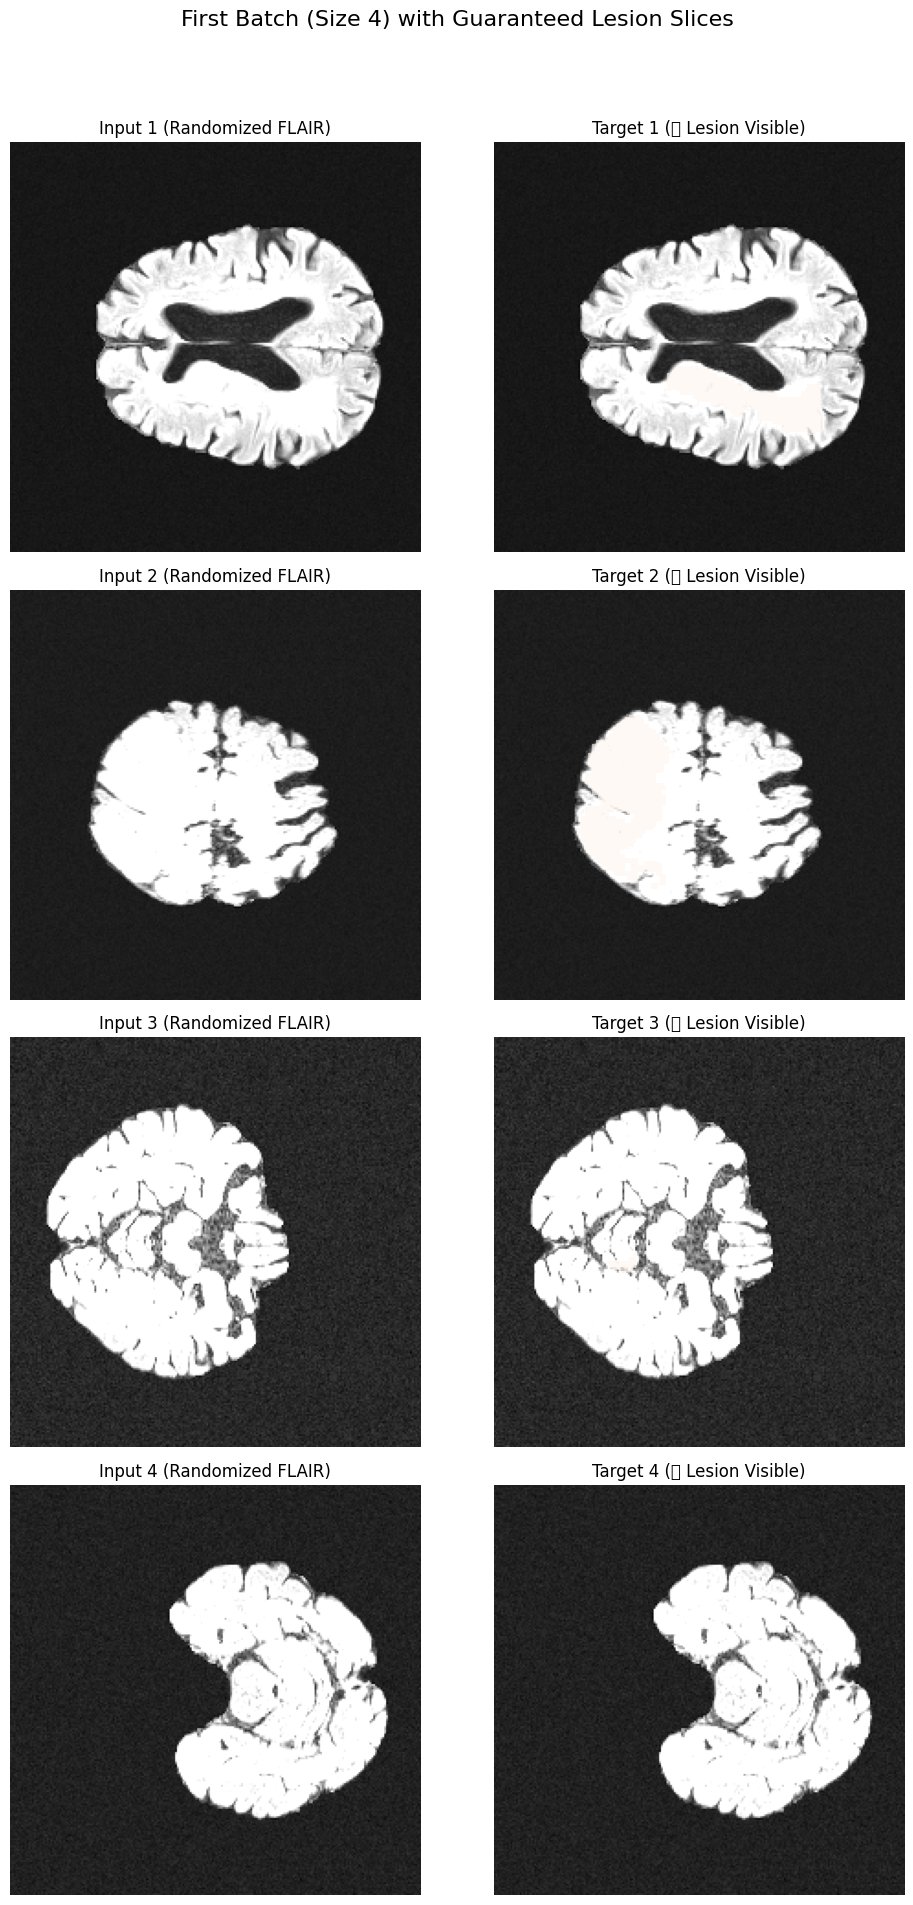

Batch shapes: Input (X): (4, 224, 224, 1), Target (Y): (4, 224, 224, 1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import Sequence

# --- ASSUMPTION ---
# This dictionary represents the "pre-collected" data after you ran the first script
# and stored the results. It's a key step you would have to run once outside the generator.
# For demonstration, we'll simulate the data collection for one case.
# In a real scenario, this would be a list of 3D (FLAIR, MASK) tuples.

# The following is a SIMULATION of pre-collected data for a few cases:
def simulate_pre_collected_data(num_cases=5):
    """
    Creates dummy 3D data where the mask is already resampled to FLAIR geometry.
    Shape: (192, 256, 120)
    """
    data_list = []
    base_shape = (192, 256, 120)
    for i in range(num_cases):
        # Simulate FLAIR data (normalized random noise + a bright "lesion" area)
        flair_data = np.random.rand(*base_shape).astype(np.float32)
        
        # Simulate Mask (already resampled)
        mask_data = np.zeros(base_shape, dtype=np.float32)
        # Add a random 'lesion' patch (e.g., a square)
        cx, cy, cz = np.random.randint(50, 150, 3)
        mask_data[cx-10:cx+10, cy-10:cy+10, cz-5:cz+5] = 1.0 

        # Add intensity noise to FLAIR to simulate domain variation
        flair_data += np.random.normal(0, random.uniform(0.1, 0.3), base_shape)

        data_list.append((flair_data, mask_data, f"Case_{i+1}"))
    return data_list

# --- NEW GENERATOR CLASS ---

class PreLoadedNiftiGenerator(Sequence):
    """
    Keras Sequence for data that is ALREADY loaded, resampled, and in RAM (e.g., a list of 3D arrays).
    It only applies 2D slicing and Domain Randomization.
    """
    def __init__(self, data_list, img_size, batch_size):
        # data_list is now a list of pre-resampled 3D tuples: [(FLAIR_3D, MASK_3D, case_id), ...]
        self.data_list = data_list
        self.img_size = img_size
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data_list) / self.batch_size))

    def on_epoch_end(self):
        random.shuffle(self.data_list)
    
    # (The _apply_domain_randomization method remains the same)
    def _apply_domain_randomization(self, img, mask):
        # ... (same DR logic as before: contrast, noise, flip, rotate) ...
        alpha = random.uniform(0.8, 1.2) # Contrast
        beta = random.uniform(-0.1, 0.1) # Brightness
        img = img * alpha + beta
        noise_level = random.uniform(0.005, 0.02)
        img += np.random.normal(0, noise_level, img.shape)
        if random.random() < 0.5:
            img, mask = np.fliplr(img), np.fliplr(mask)
        rotations = random.choice([0, 1, 2, 3])
        if rotations > 0:
            img, mask = np.rot90(img, k=rotations).copy(), np.rot90(mask, k=rotations).copy()
        img = np.clip(img, 0, 1)
        mask = (mask > 0).astype(np.float32)
        return img, mask

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_data = self.data_list[start_idx:end_idx]
        
        X = np.empty((len(batch_data), *self.img_size, 1), dtype=np.float32)
        Y = np.empty((len(batch_data), *self.img_size, 1), dtype=np.float32)

        for i, (flair_3d, mask_3d, case_id) in enumerate(batch_data):
            
            # Normalization (needed here if not done during initial collection)
            flair_3d = (flair_3d - np.mean(flair_3d)) / (np.std(flair_3d) + 1e-6)
            flair_3d = np.clip(flair_3d, -3, 3) / 6.0 + 0.5 # Scale to ~[0, 1]

            # 3D to 2D Slicing (Domain Randomization)
            max_slice = flair_3d.shape[2] - 1
            slice_idx = random.randint(int(max_slice * 0.2), int(max_slice * 0.8))
            
            X_slice = flair_3d[:, :, slice_idx]
            Y_slice = mask_3d[:, :, slice_idx]

            # Resize (last stage of geometric DR)
            X_slice = np.array(plt.resize(X_slice, self.img_size))
            Y_slice = np.array(plt.resize(Y_slice, self.img_size, order=0))

            # Apply Domain Randomization (Noise, Contrast, Flip, Rotate)
            X_slice_dr, Y_slice_dr = self._apply_domain_randomization(X_slice, Y_slice)
            
            X[i, :, :, 0] = X_slice_dr
            Y[i, :, :, 0] = Y_slice_dr

        return X, Y

# --- Execution and Visualization (SIMULATED) ---
IMG_SIZE = (224, 224) 
BATCH_SIZE = 4

# 1. Simulate the data collection step
pre_collected_data = simulate_pre_collected_data(num_cases=10)
print(f"Simulated {len(pre_collected_data)} pre-collected cases.")

# 2. Initialize the pre-loaded generator
data_generator = PreLoadedNiftiGenerator(
    data_list=pre_collected_data,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# 3. Visualize the first randomized batch
X_batch, Y_batch = data_generator[0]

fig, axes = plt.subplots(BATCH_SIZE, 2, figsize=(10, 5 * BATCH_SIZE))
fig.suptitle(f"First Pre-Loaded Batch (Size {BATCH_SIZE}) with Domain Randomization", fontsize=16)

for i in range(BATCH_SIZE):
    ax_img = axes[i, 0]
    ax_img.imshow(X_batch[i, :, :, 0].T, cmap="gray", origin="lower")
    ax_img.set_title(f"Input {i+1} (Randomized FLAIR)")
    ax_img.axis("off")

    ax_mask = axes[i, 1]
    ax_mask.imshow(X_batch[i, :, :, 0].T, cmap="gray", origin="lower") 
    lesion_overlay = np.where(Y_batch[i, :, :, 0].T > 0, Y_batch[i, :, :, 0].T, np.nan)
    ax_mask.imshow(lesion_overlay, cmap="Reds", alpha=0.6, origin="lower")
    ax_mask.set_title(f"Target {i+1} (Lesion Overlay)")
    ax_mask.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Error: Lesion appears empty after resampling. Cannot find any mask voxels.
Lesion found on AXIS 2 at slice index: 176


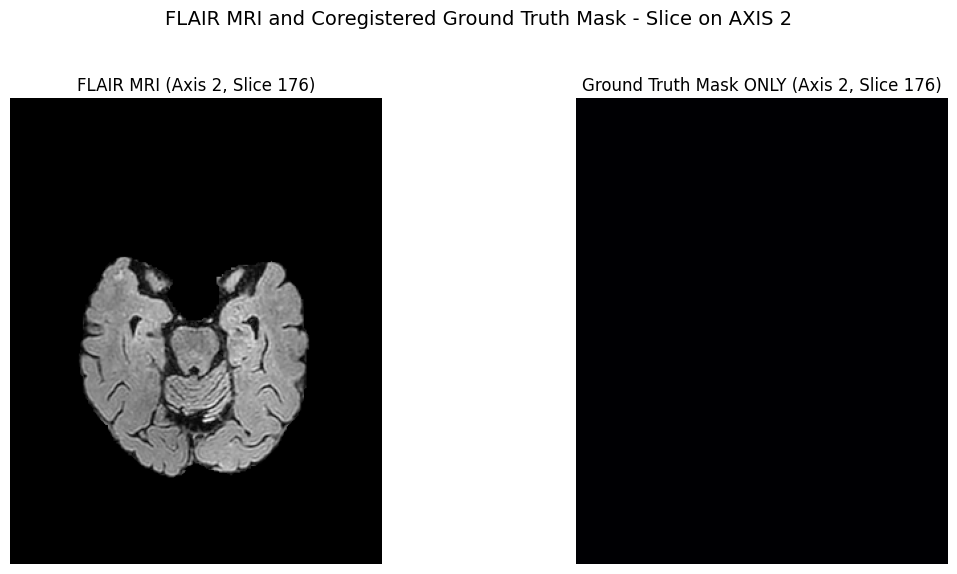

In [48]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy.ndimage import affine_transform

# --- File Paths (Assuming they are accessible from your environment) ---
nii_file = "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_FLAIR.nii"
mask_nii_file = "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022/derivatives/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_msk.nii"

# --- 1. Load Data and Affine Matrices (Resampling is correct) ---
flair_img = nib.load(nii_file)
flair_data = flair_img.get_fdata()
flair_affine = flair_img.affine

mask_img = nib.load(mask_nii_file)
mask_data = mask_img.get_fdata()
mask_affine = mask_img.affine

transform_matrix = np.linalg.inv(flair_affine) @ mask_affine

resampled_mask_data = affine_transform(
    input=mask_data,
    matrix=transform_matrix,
    output_shape=flair_data.shape,
    order=0,
    mode='constant',
    cval=0.0
)

# ----------------------------------------------------------------------
# --- 2. NEW: SEARCH ALL DIMENSIONS TO FIND THE MOST VISIBLE LESION ---
# ----------------------------------------------------------------------

max_lesion_voxels = 0
best_axis = -1
best_slice_idx = -1

# Check each axis (0, 1, 2) to see where the lesion is most visible
for axis in range(3):
    # Sum lesion voxels across the other two dimensions
    axes_to_sum = tuple(a for a in range(3) if a != axis)
    lesion_area_per_slice = np.sum(resampled_mask_data, axis=axes_to_sum)
    
    if np.max(lesion_area_per_slice) > max_lesion_voxels:
        max_lesion_voxels = np.max(lesion_area_per_slice)
        best_slice_idx = np.argmax(lesion_area_per_slice)
        best_axis = axis

if best_axis == -1:
    print("Error: Lesion appears empty after resampling. Cannot find any mask voxels.")
    # Fallback to the original user slice if no lesion is found
    best_axis = 2
    best_slice_idx = flair_data.shape[2] // 2 

print(f"Lesion found on AXIS {best_axis} at slice index: {best_slice_idx}")

# --- 3. Extract and Plot the Corrected Slice ---
# Prepare the slicing object to select the correct slice plane
slice_selection = [slice(None)] * 3
slice_selection[best_axis] = best_slice_idx

slice_flair = flair_data[tuple(slice_selection)]
slice_mask = resampled_mask_data[tuple(slice_selection)]

# Transpose the slice for plotting (needed for proper orientation, which often involves the first two dimensions)
slice_flair_T = slice_flair.T if slice_flair.shape[0] < slice_flair.shape[1] else slice_flair
slice_mask_T = slice_mask.T if slice_mask.shape[0] < slice_mask.shape[1] else slice_mask


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: FLAIR Image
axes[0].imshow(slice_flair_T, cmap="gray", origin="lower")
axes[0].set_title(f"FLAIR MRI (Axis {best_axis}, Slice {best_slice_idx})")
axes[0].axis("off")

# Plot 2: Resampled Mask ONLY
axes[1].imshow(slice_mask_T, cmap="magma", origin="lower")
axes[1].set_title(f"Ground Truth Mask ONLY (Axis {best_axis}, Slice {best_slice_idx})")
axes[1].axis("off")

plt.suptitle(f"FLAIR MRI and Coregistered Ground Truth Mask - Slice on AXIS {best_axis}", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [35]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
from scipy.ndimage import gaussian_filter, zoom, rotate

# -------------------------
#   Custom Dataset
# -------------------------
class MRIDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = nib.load(self.image_paths[idx]).get_fdata().astype(np.float32)
        msk = nib.load(self.mask_paths[idx]).get_fdata().astype(np.int64)

        # Normalize (0–1)
        img = np.clip(img, 0, 2000) / 2000.0

        if self.augment:
            img, msk = self.random_augment(img, msk)

        # Add channel dimension [C, D, H, W]
        img = torch.from_numpy(img).unsqueeze(0)  # channel first
        msk = torch.from_numpy(msk).unsqueeze(0)

        return {"image": img, "label": msk}

    # -------------------------
    #   Augmentations
    # -------------------------
    def random_augment(self, img, msk):
        # ---- Intensity ----
        if random.random() < 0.3:  # Gaussian noise
            noise = np.random.normal(0, 0.05, img.shape)
            img = img + noise

        if random.random() < 0.3:  # Gaussian blur
            sigma = np.random.uniform(0.5, 1.5)
            img = gaussian_filter(img, sigma=sigma)

        if random.random() < 0.3:  # Contrast adjustment
            gamma = np.random.uniform(0.7, 1.5)
            img = np.power(img, gamma)

        if random.random() < 0.3:  # Bias field (low-freq smooth intensity shift)
            bias = gaussian_filter(np.random.randn(*img.shape), sigma=50)
            bias = (bias - bias.min()) / (bias.max() - bias.min())  # normalize 0–1
            img = img * (0.5 + 0.5 * bias)

        # ---- Spatial ----
        if random.random() < 0.5:  # Small rotation
            angle = np.random.uniform(-6, 6)  # degrees
            img = rotate(img, angle, axes=(0, 1), reshape=False, order=1)
            msk = rotate(msk, angle, axes=(0, 1), reshape=False, order=0)

        # if random.random() < 0.3:  # 30% chance
        #     # pick a separate zoom factor for each axis (D, H, W)
        #     zoom_factors = np.random.uniform(0.9, 1.1, size=3)  
        #     img = zoom(img, zoom_factors, order=1)   # linear for image
        #     msk = zoom(msk, zoom_factors, order=0)   # nearest for mask


            # pad/crop back to original shape
            # img, msk = self._match_shape(img, msk, target_shape=(281,281,281))  # adjust to your dataset

        return img, msk

    def _match_shape(self, img, msk, target_shape):
        """ Pad or crop image/mask to target shape """
        def pad_or_crop(vol, target_shape, order):
            out = np.zeros(target_shape, dtype=vol.dtype)
            # crop
            min_shape = [min(s, t) for s, t in zip(vol.shape, target_shape)]
            slices_in = tuple(slice(0, m) for m in min_shape)
            slices_out = tuple(slice(0, m) for m in min_shape)
            out[slices_out] = vol[slices_in]
            return out
        return pad_or_crop(img, target_shape, 1), pad_or_crop(msk, target_shape, 0)

# -------------------------
#   Example Usage
# -------------------------
flair_paths = [
    "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_FLAIR.nii"
]
mask_paths = [
    "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022/derivatives/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_msk.nii"
]

train_ds = MRIDataset(flair_paths, mask_paths, augment=True)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

batch = next(iter(train_loader))
print("Image shape:", batch["image"].shape)  # [B, C, D, H, W]
print("Label shape:", batch["label"].shape)


Image shape: torch.Size([1, 1, 281, 352, 352])
Label shape: torch.Size([1, 1, 112, 112, 73])


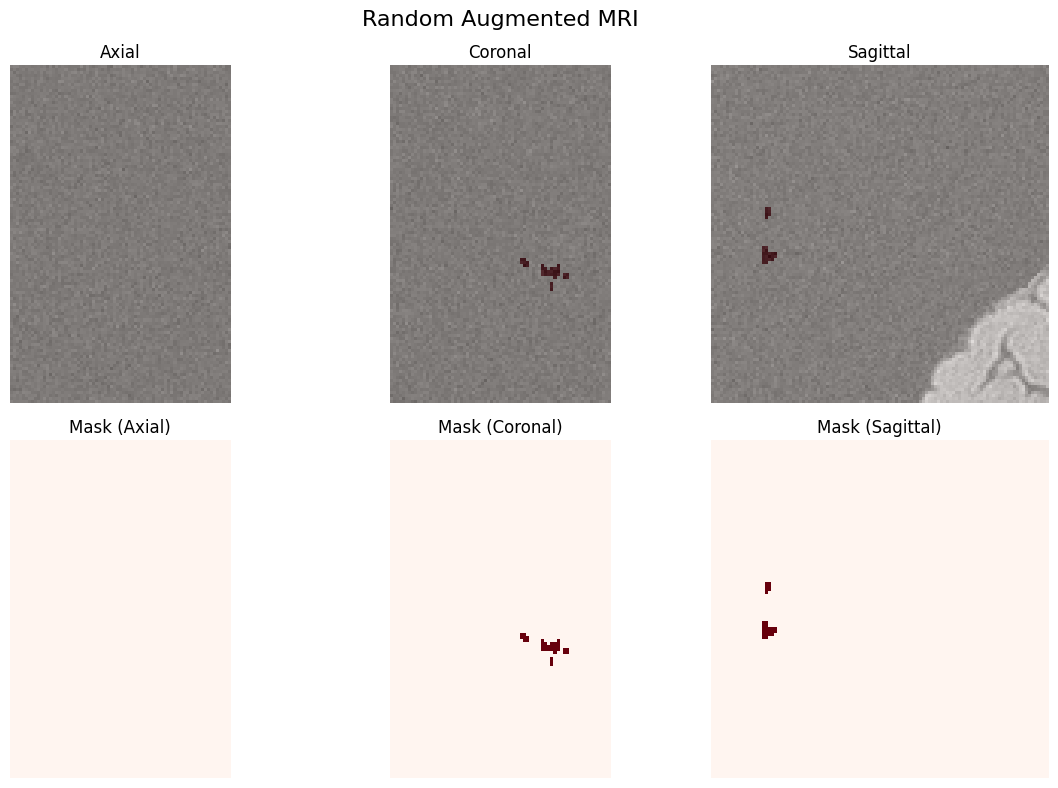

In [31]:
import matplotlib.pyplot as plt

def show_slices(image_tensor, mask_tensor, title="Augmented MRI"):
    """
    Visualize axial, coronal, sagittal middle slices of a 3D MRI + mask.
    Handles different shapes safely.
    """
    img = image_tensor.squeeze().numpy()  # [D, H, W]
    msk = mask_tensor.squeeze().numpy()   # [D, H, W]

    # mid-slices for each
    mid_img = [img.shape[0]//2, img.shape[1]//2, img.shape[2]//2]
    mid_msk = [msk.shape[0]//2, msk.shape[1]//2, msk.shape[2]//2]
   
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(title, fontsize=16)

    # Axial
    axes[0,0].imshow(img[mid_img[0], :, :], cmap="gray")
    if mid_msk[0] < msk.shape[0]:
        axes[0,0].imshow(msk[mid_msk[0], :, :], alpha=0.4, cmap="Reds")
    axes[0,0].set_title("Axial")

    # Coronal
    axes[0,1].imshow(img[:, mid_img[1], :], cmap="gray")
    if mid_msk[1] < msk.shape[1]:
        axes[0,1].imshow(msk[:, mid_msk[1], :], alpha=0.4, cmap="Reds")
    axes[0,1].set_title("Coronal")

    # Sagittal
    axes[0,2].imshow(img[:, :, mid_img[2]], cmap="gray")
    if mid_msk[2] < msk.shape[2]:
        axes[0,2].imshow(msk[:, :, mid_msk[2]], alpha=0.4, cmap="Reds")
    axes[0,2].set_title("Sagittal")

    # Mask-only row
    axes[1,0].imshow(msk[mid_msk[0], :, :], cmap="Reds"); axes[1,0].set_title("Mask (Axial)")
    axes[1,1].imshow(msk[:, mid_msk[1], :], cmap="Reds"); axes[1,1].set_title("Mask (Coronal)")
    axes[1,2].imshow(msk[:, :, mid_msk[2]], cmap="Reds"); axes[1,2].set_title("Mask (Sagittal)")

    for ax in axes.ravel():
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# ---- Try visualization ----
batch = next(iter(train_loader))
show_slices(batch["image"], batch["label"], title="Random Augmented MRI")


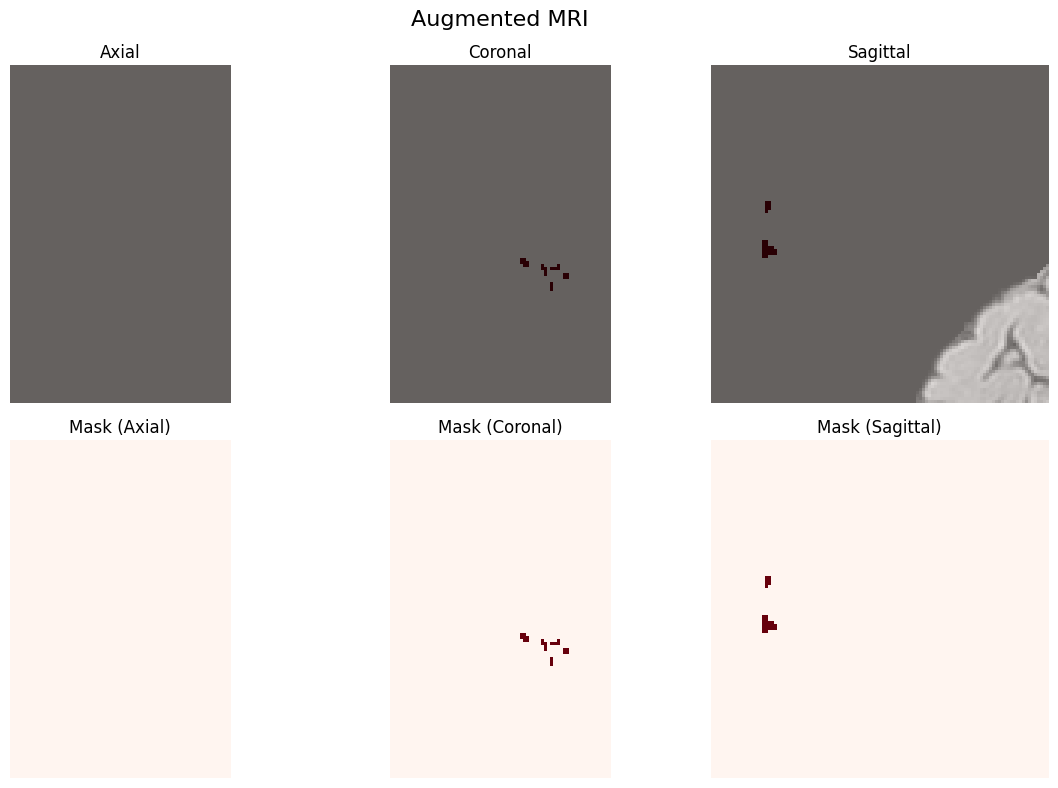

/tmp/ipykernel_36/3103462834.py:53: RuntimeWarning: invalid value encountered in power
  img = np.power(img, gamma)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


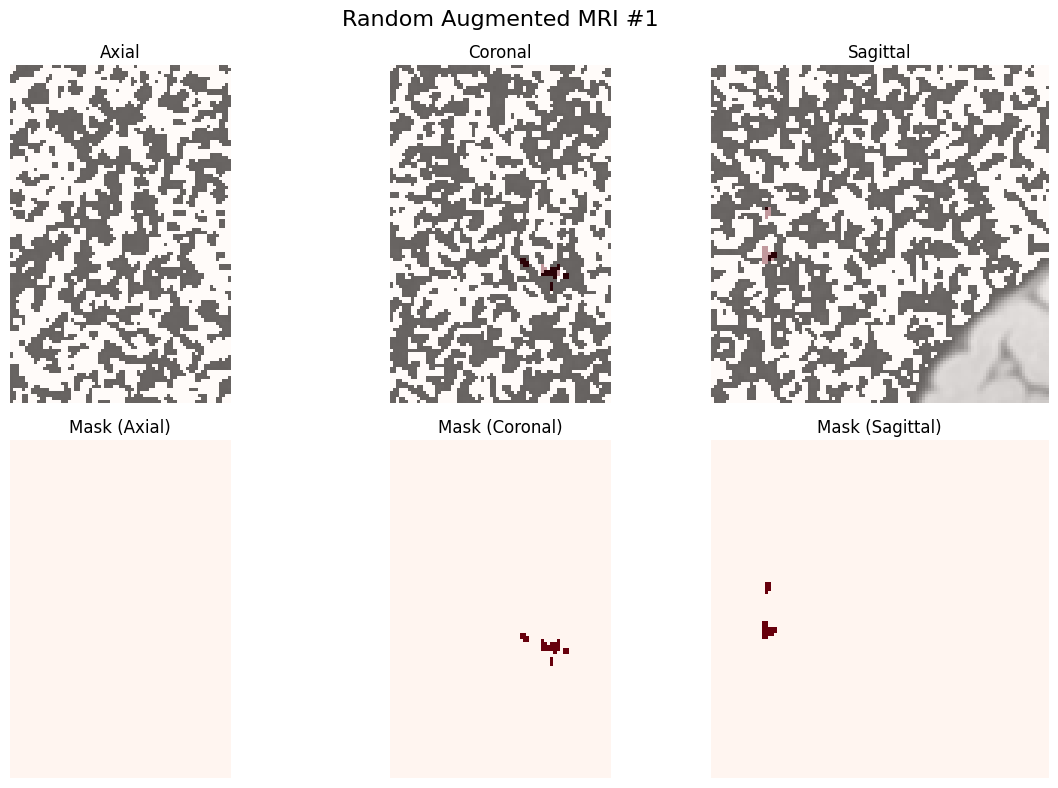

In [36]:
batch = next(iter(train_loader))
show_slices(batch["image"], batch["label"])
# Show N samples from the dataloader
N = 4   # how many augmented examples to show

for i, batch in enumerate(train_loader):
    if i >= N:
        break
    show_slices(batch["image"], batch["label"], title=f"Random Augmented MRI #{i+1}")


In [46]:
import os
import nibabel as nib
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, ScaleIntensityRanged,
    RandGaussianNoised, RandGaussianSmoothd, RandAdjustContrastd,
    RandBiasFieldd, RandAffined, RandElasticd, RandZoomd,
    ToTensord, Compose
)
from monai.data import Dataset, DataLoader

# Example paths
flair_paths = [
    "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_FLAIR.nii"
]
mask_paths = [
    "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_seg.nii"
]

# Create dicts for MONAI Dataset
data_dicts = [{"image": i, "label": m} for i, m in zip(flair_paths, mask_paths)]

# ---- DOMAIN RANDOMIZATION TRANSFORMS ----
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),

    # ---- intensity randomization ----
    ScaleIntensityRanged(keys="image", a_min=0, a_max=2000, b_min=0.0, b_max=1.0, clip=True),
    RandGaussianNoised(keys="image", prob=0.3, mean=0.0, std=0.05),
    RandGaussianSmoothd(keys="image", prob=0.3, sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5), sigma_z=(0.5, 1.5)),
    RandAdjustContrastd(keys="image", prob=0.3, gamma=(0.7, 1.5)),
    RandBiasFieldd(keys="image", prob=0.3, coeff_range=(0.0, 0.5)),

    # ---- spatial randomization ----
    RandAffined(
        keys=["image", "label"], prob=0.5,
        rotate_range=(0.1, 0.1, 0.1),   # ~±6°
        scale_range=(0.1, 0.1, 0.1),
        mode=("bilinear", "nearest")
    ),
    RandElasticd(
        keys=["image", "label"], prob=0.3,
        sigma_range=(5, 7), magnitude_range=(50, 100),
        mode=("bilinear", "nearest")
    ),
    RandZoomd(
        keys=["image", "label"], prob=0.3,
        min_zoom=0.7, max_zoom=1.3,
        mode=("trilinear", "nearest")
    ),

    ToTensord(keys=["image", "label"])
])

# ---- Dataset + Loader ----
train_ds = Dataset(data=data_dicts, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

# ---- visualize one sample ----
batch = next(iter(train_loader))
print("Image shape:", batch["image"].shape)
print("Label shape:", batch["label"].shape)


ModuleNotFoundError: No module named 'monai'